<h1>ROCK CHALLENGE: video analysis (MobileNet)</h1>
<p>Un précédent projet intitulé « rock challenge : image classification » visait à créer un modèle pour classer si une image contient une roche :
    <ul>
        <li>Larges</li>
        <li>Médium</li>
        <li>Pellets</li>
        <li>Fines</li>
    </ul>  
</p>
<p>C'est à partir de ce modèle que nous allons créer ce nouveau projet.</p>
<p> - Elle consiste à analyser un flux vidéo d'un tas de roches glissant sur un tapis afin de s'assurer si le tas est homogène ou s'il contient des roches différentes.</p>
<p> - Le système envoie des notifications en cas de détection d'impuretés ou de changement de type de roche.</p>
<p> - L'opération se fera avec un Rasberry Pi, ce qui nous contraint à un temps de prédiction de 150ms/frame. Ici le temps d'execution sera afficher pour vérifier.</p>
<p> - Un graphique montrant les pourcentages de chaque type de roche pour chaque image de la vidéo sera alors généré pour une vue d'ensemble.</p>

<h2>1) Import des dépendances</h2>

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from PIL import Image
import time
import math

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.mobilenet import preprocess_input
from tensorflow.keras import Model, layers
from tensorflow.keras.models import load_model, model_from_json

<h2>2) Chargement du model</h2>

In [2]:
model = keras.models.load_model('./models/mobilenet_top.h5')

<h2>3) Les fonctions:</h2>

<ul><li><h3>Découpage de l'image</h3><span>Découpe la frame en plusieur petit grille de taille grid_size (w, h).</span></li></ul>


In [3]:
def split_image(frame, grid_size=(160, 213)):
    H = frame.shape[0]
    W = frame.shape[1]
    h = grid_size[0]
    w = grid_size[1]
    nbr_h = H//h 
    nbr_w = W//w
    grids = []
    grid = np.zeros((h, w, 3))
    
    i=0
    for y in range(0, H, h):
        for x in range(0, W, w):
            grid = frame[y:y+h, x:x+w, :]
            grids.append(grid)
            
    return grids

<ul><li><h3>Pré-traitement des grilles d'images</h3><span>Applique une pré-traitement (le même que celui utiliser lors du trainning du model) à chaque image de la liste du grilles d'image.</span></li></ul>

In [4]:
def preprocess_images(grids):
    dim = (160, 160)
    X = []
    preds = []
    for image in grids:
        #print(image.shape)
        img = cv2.resize(image, dim, interpolation=cv2.INTER_LINEAR)
        x = cv2.cvtColor(img , cv2.COLOR_BGR2RGB)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)
        X.append(x)
    return X

<ul><li><h3>Prédiction</h3><span>Prédiction sur chaque images de la liste du grille d'image .</span></li></ul>

In [5]:
def predict_image_list(model, X):
    preds = []
    for x in model.predict(np.vstack(X)):
        preds.append(np.argmax(x))
    return preds

<ul><li><h3>Affichage de la vidéo</h3><span></span></li></ul>

In [6]:
def display_video (filepath) :
  cap = cv2.VideoCapture(filepath)
  predictions = []
  i = 0
  times = []
  while True:
      i+=1
      start = time.time()
      ret, frame = cap.read()

      if ret == False:
          break

      grids = split_image(frame, (math.ceil(480/3), math.ceil(640/3)))
      X     = preprocess_images(grids)
      preds = predict_image_list(model, X)
      predictions.append(preds)

      if len(np.unique(preds)) > 1:
          print('Mixed or changed on frame number: ',i)

      end = time.time()
      times.append(end - start)
      if i%10 == 0:
          print('Average execution time: ', round(sum(times)/len(times), 1) * 1000, ' ms' )
          times = []
  return predictions

<ul><li><h3>Normalisation des données de prédiction</h3><span>Calcule du pourcentage de chaque type de roche (d'apres la prédiction) dans une frame</span></li></ul>

In [7]:
def normalise_preds(predictions):
    predictions_100 = []
    for pred in predictions:
        pred_100     = []
        class_counts = [] 
        uniques, counts = np.unique(pred, return_counts=True)
        
        for i in range (4):
            if i in uniques:
                index,  = np.where(uniques == i)
                class_counts.append(counts[index[0]])
            else:
                class_counts.append(0)

        for i in class_counts:
            pred_100.append(round(i/9*100, 1))

        predictions_100.append(pred_100)
        
    return predictions_100

<ul><li><h3>Affichage du graphique</h3><span>Chaque couleur correspond à un type de roche et chaque barre verticale correspond a une frame. La hauteur de la couleur correspond au pourcentage de ce roche dans chaque frame.</span></li></ul>

In [8]:
def show_graph(predictions_100):

    labels = ['fines', 'larges', 'medium', 'pellets']
    data = np.array(predictions_100)
    x    = np.arange(data.shape[0])

    fig, ax=plt.subplots(figsize=(20,10))
    for i in range(data.shape[1]):
        bottom=np.sum(data[:,0:i], axis=1)  
        ax.bar(x,data[:,i], width=1.0, bottom=bottom, label=labels[i])

    plt.legend(framealpha=1)
    plt.show()

<h2>2) Execution</h2>

<ul><li><h3>Video 1</h3></li></ul>

In [9]:
predictions = display_video("./data/bin_1.mp4")

Mixed or changed on frame number:  1
Mixed or changed on frame number:  2
Mixed or changed on frame number:  3
Mixed or changed on frame number:  4
Mixed or changed on frame number:  5
Mixed or changed on frame number:  6
Mixed or changed on frame number:  7
Mixed or changed on frame number:  8
Mixed or changed on frame number:  9
Mixed or changed on frame number:  10
Average execution time:  800.0  ms
Mixed or changed on frame number:  11
Mixed or changed on frame number:  12
Mixed or changed on frame number:  13
Mixed or changed on frame number:  14
Mixed or changed on frame number:  15
Mixed or changed on frame number:  16
Mixed or changed on frame number:  17
Mixed or changed on frame number:  18
Mixed or changed on frame number:  19
Mixed or changed on frame number:  20
Average execution time:  100.0  ms
Mixed or changed on frame number:  21
Mixed or changed on frame number:  22
Mixed or changed on frame number:  23
Mixed or changed on frame number:  24
Mixed or changed on frame n

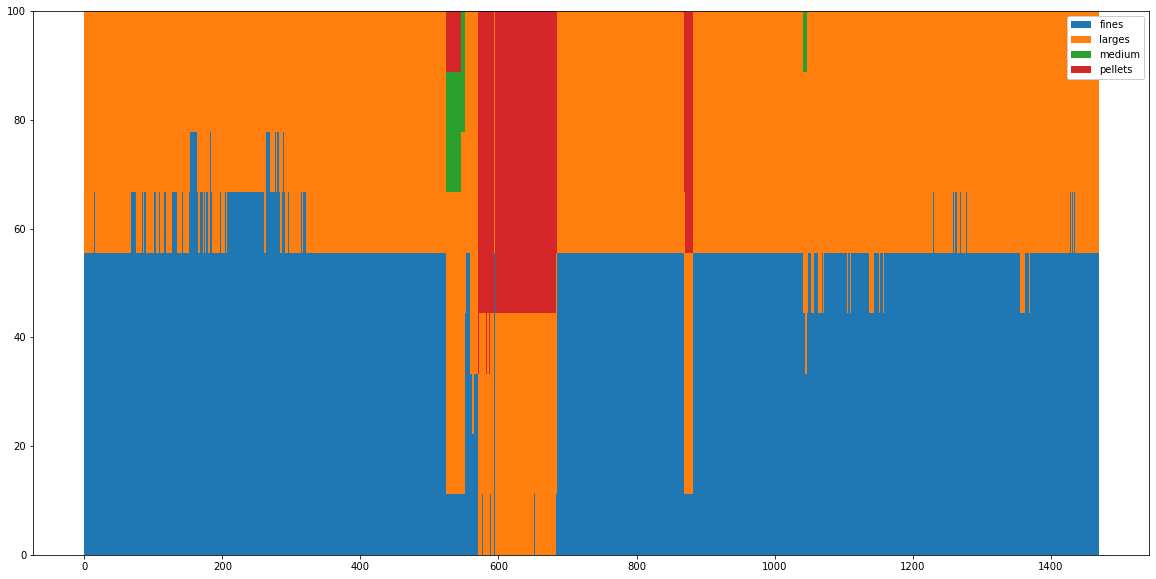

In [10]:
predictions_100 = normalise_preds(predictions)
show_graph(predictions_100)

<ul><li><h3>Video 2</h3></li></ul>

In [11]:
predictions = display_video("./data/bin_2.mp4")

Mixed or changed on frame number:  3
Mixed or changed on frame number:  5
Mixed or changed on frame number:  8
Mixed or changed on frame number:  10
Average execution time:  100.0  ms
Mixed or changed on frame number:  11
Mixed or changed on frame number:  12
Mixed or changed on frame number:  13
Mixed or changed on frame number:  14
Mixed or changed on frame number:  15
Mixed or changed on frame number:  16
Mixed or changed on frame number:  17
Mixed or changed on frame number:  18
Mixed or changed on frame number:  19
Mixed or changed on frame number:  20
Average execution time:  100.0  ms
Mixed or changed on frame number:  21
Mixed or changed on frame number:  22
Mixed or changed on frame number:  23
Mixed or changed on frame number:  24
Mixed or changed on frame number:  25
Mixed or changed on frame number:  26
Mixed or changed on frame number:  27
Mixed or changed on frame number:  28
Mixed or changed on frame number:  29
Mixed or changed on frame number:  30
Average execution tim

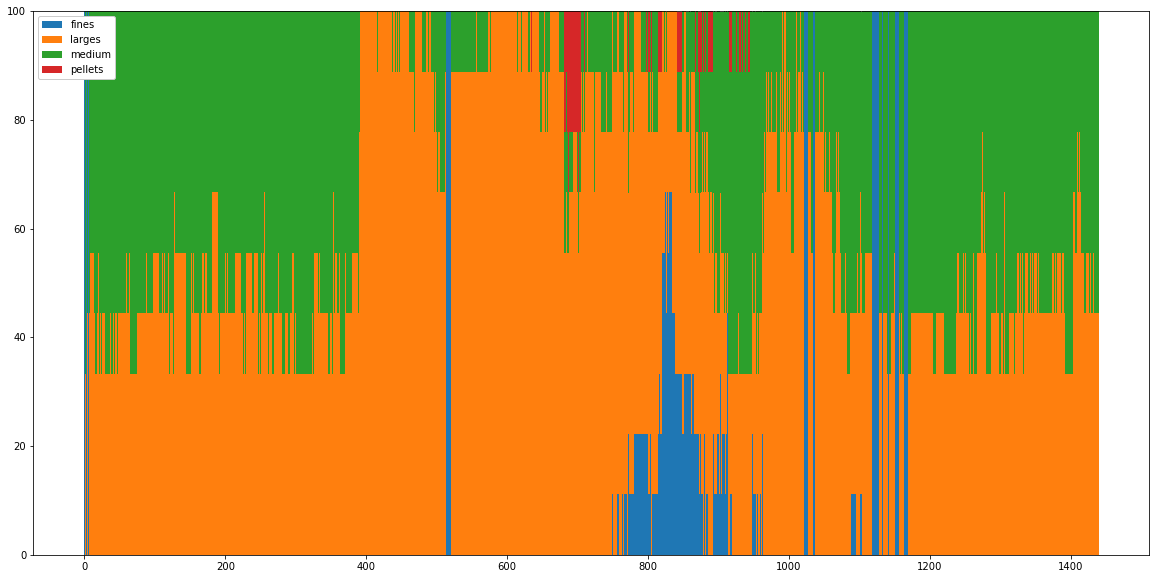

In [12]:
predictions_100 = normalise_preds(predictions)
show_graph(predictions_100)

<ul><li><h3>Video 3</h3></li></ul>

In [13]:
predictions = display_video("./data/bin_3.mp4")

Mixed or changed on frame number:  1
Mixed or changed on frame number:  2
Mixed or changed on frame number:  3
Mixed or changed on frame number:  4
Mixed or changed on frame number:  5
Mixed or changed on frame number:  6
Mixed or changed on frame number:  7
Mixed or changed on frame number:  8
Mixed or changed on frame number:  9
Mixed or changed on frame number:  10
Average execution time:  100.0  ms
Mixed or changed on frame number:  11
Mixed or changed on frame number:  12
Mixed or changed on frame number:  13
Mixed or changed on frame number:  14
Mixed or changed on frame number:  15
Mixed or changed on frame number:  16
Mixed or changed on frame number:  17
Mixed or changed on frame number:  18
Mixed or changed on frame number:  19
Mixed or changed on frame number:  20
Average execution time:  100.0  ms
Mixed or changed on frame number:  21
Mixed or changed on frame number:  22
Mixed or changed on frame number:  23
Mixed or changed on frame number:  24
Mixed or changed on frame n

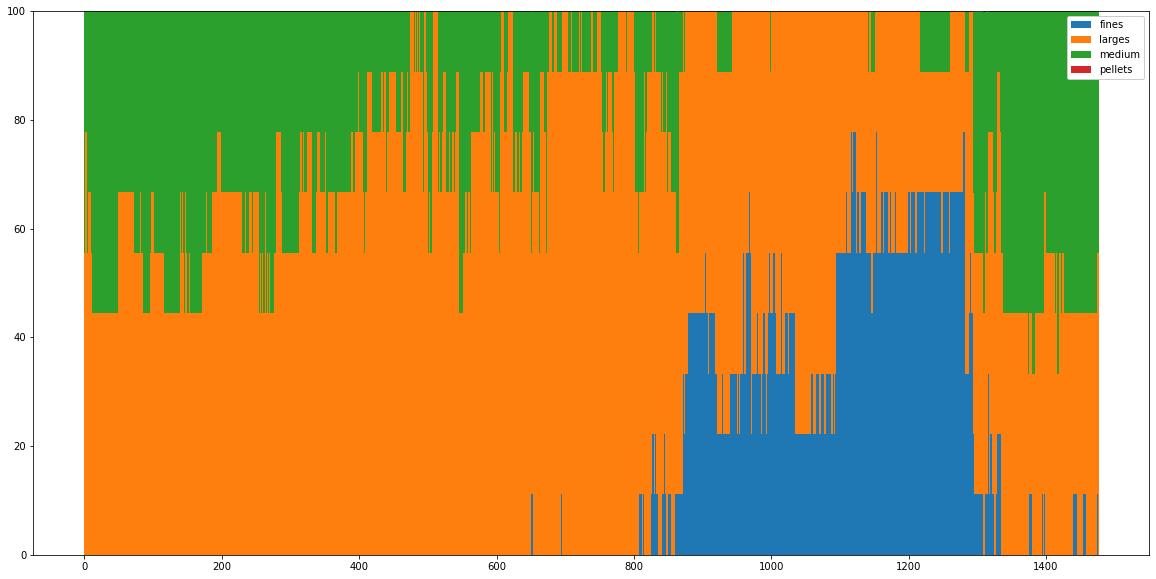

In [14]:
predictions_100 = normalise_preds(predictions)
show_graph(predictions_100)

<ul><li><h3>Video 4</h3></li></ul>

In [15]:
predictions = display_video("./data/bin_4.mp4")

Average execution time:  100.0  ms
Average execution time:  100.0  ms
Average execution time:  100.0  ms
Average execution time:  100.0  ms
Average execution time:  100.0  ms
Average execution time:  100.0  ms
Average execution time:  100.0  ms
Average execution time:  100.0  ms
Average execution time:  100.0  ms
Mixed or changed on frame number:  91
Mixed or changed on frame number:  95
Mixed or changed on frame number:  97
Mixed or changed on frame number:  98
Average execution time:  100.0  ms
Average execution time:  100.0  ms
Mixed or changed on frame number:  114
Mixed or changed on frame number:  115
Average execution time:  100.0  ms
Mixed or changed on frame number:  124
Mixed or changed on frame number:  125
Average execution time:  100.0  ms
Average execution time:  100.0  ms
Average execution time:  100.0  ms
Average execution time:  100.0  ms
Mixed or changed on frame number:  163
Mixed or changed on frame number:  164
Average execution time:  100.0  ms
Average execution t

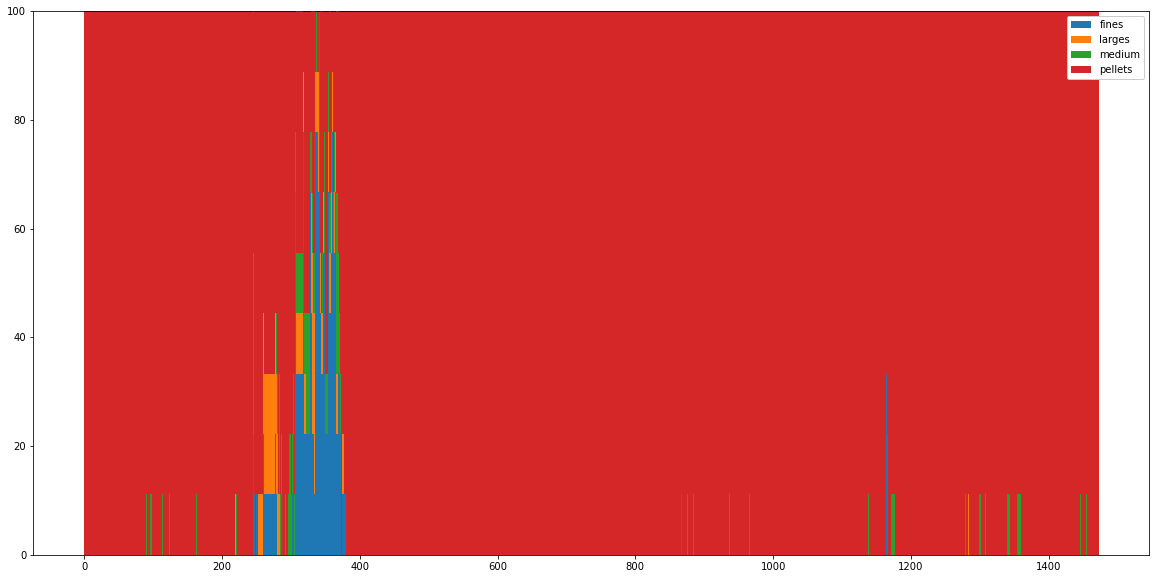

In [16]:
predictions_100 = normalise_preds(predictions)
show_graph(predictions_100)

<ul><li><h3>Video 5</h3></li></ul>

In [17]:
predictions = display_video("./data/bin_5.mp4")

Mixed or changed on frame number:  1
Mixed or changed on frame number:  2
Mixed or changed on frame number:  3
Mixed or changed on frame number:  4
Mixed or changed on frame number:  5
Mixed or changed on frame number:  6
Mixed or changed on frame number:  7
Mixed or changed on frame number:  8
Mixed or changed on frame number:  9
Mixed or changed on frame number:  10
Average execution time:  100.0  ms
Mixed or changed on frame number:  11
Mixed or changed on frame number:  12
Mixed or changed on frame number:  13
Mixed or changed on frame number:  14
Mixed or changed on frame number:  15
Mixed or changed on frame number:  16
Mixed or changed on frame number:  17
Mixed or changed on frame number:  18
Mixed or changed on frame number:  19
Mixed or changed on frame number:  20
Average execution time:  100.0  ms
Mixed or changed on frame number:  21
Mixed or changed on frame number:  22
Mixed or changed on frame number:  23
Mixed or changed on frame number:  24
Mixed or changed on frame n

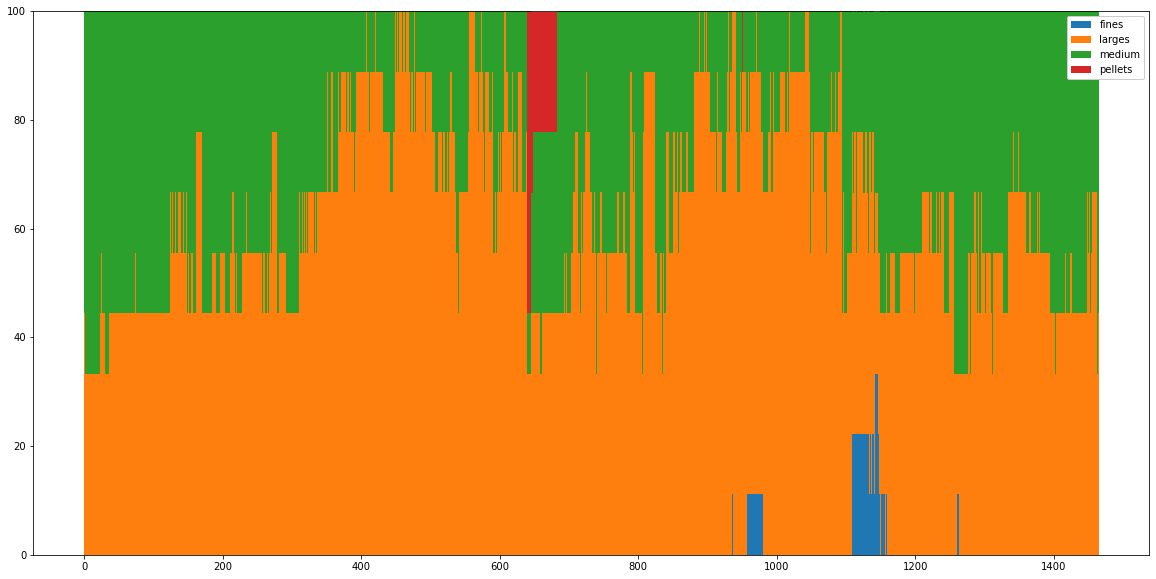

In [18]:
predictions_100 = normalise_preds(predictions)
show_graph(predictions_100)

<ul><li><h3>Video 6</h3></li></ul>

In [19]:
predictions = display_video("./data/bin_6.mp4")

Average execution time:  100.0  ms
Mixed or changed on frame number:  12
Mixed or changed on frame number:  13
Mixed or changed on frame number:  19
Mixed or changed on frame number:  20
Average execution time:  100.0  ms
Mixed or changed on frame number:  28
Average execution time:  100.0  ms
Mixed or changed on frame number:  36
Mixed or changed on frame number:  37
Average execution time:  100.0  ms
Mixed or changed on frame number:  42
Mixed or changed on frame number:  43
Mixed or changed on frame number:  44
Average execution time:  100.0  ms
Mixed or changed on frame number:  51
Mixed or changed on frame number:  57
Average execution time:  100.0  ms
Mixed or changed on frame number:  64
Mixed or changed on frame number:  65
Average execution time:  100.0  ms
Mixed or changed on frame number:  73
Mixed or changed on frame number:  74
Average execution time:  100.0  ms
Mixed or changed on frame number:  83
Mixed or changed on frame number:  84
Average execution time:  100.0  ms
M

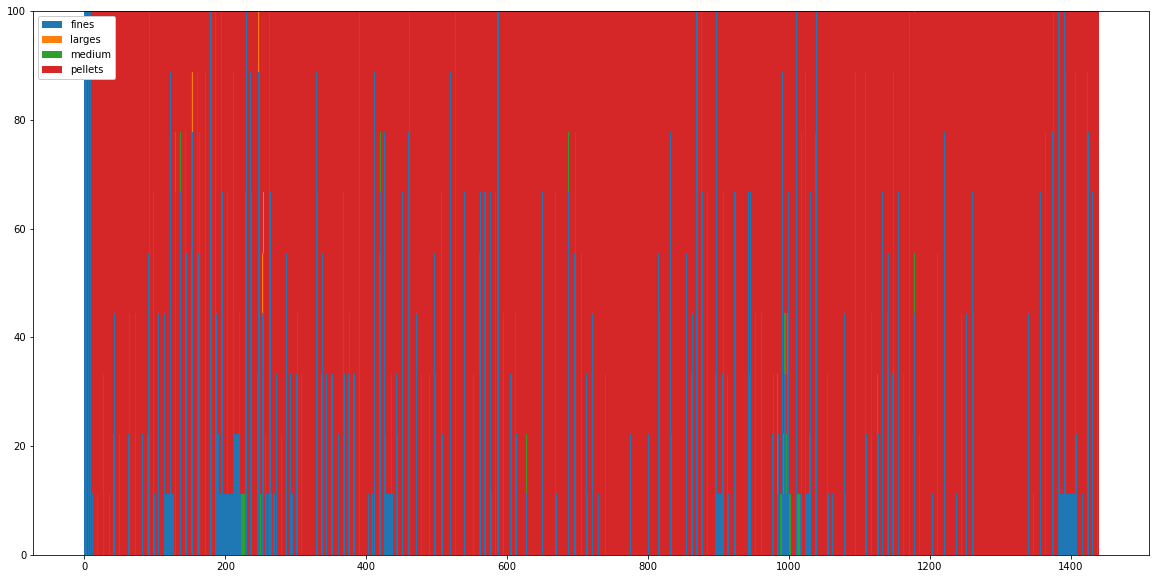

In [20]:
predictions_100 = normalise_preds(predictions)
show_graph(predictions_100)

<ul><li><h3>Video 7</h3></li></ul>

In [21]:
predictions = display_video("./data/bin_7.mp4")

Mixed or changed on frame number:  1
Mixed or changed on frame number:  2
Mixed or changed on frame number:  3
Mixed or changed on frame number:  4
Mixed or changed on frame number:  5
Mixed or changed on frame number:  6
Mixed or changed on frame number:  7
Mixed or changed on frame number:  8
Mixed or changed on frame number:  9
Mixed or changed on frame number:  10
Average execution time:  100.0  ms
Mixed or changed on frame number:  11
Mixed or changed on frame number:  12
Mixed or changed on frame number:  13
Mixed or changed on frame number:  14
Mixed or changed on frame number:  15
Mixed or changed on frame number:  16
Mixed or changed on frame number:  17
Mixed or changed on frame number:  18
Mixed or changed on frame number:  19
Mixed or changed on frame number:  20
Average execution time:  100.0  ms
Mixed or changed on frame number:  21
Mixed or changed on frame number:  22
Mixed or changed on frame number:  23
Mixed or changed on frame number:  24
Mixed or changed on frame n

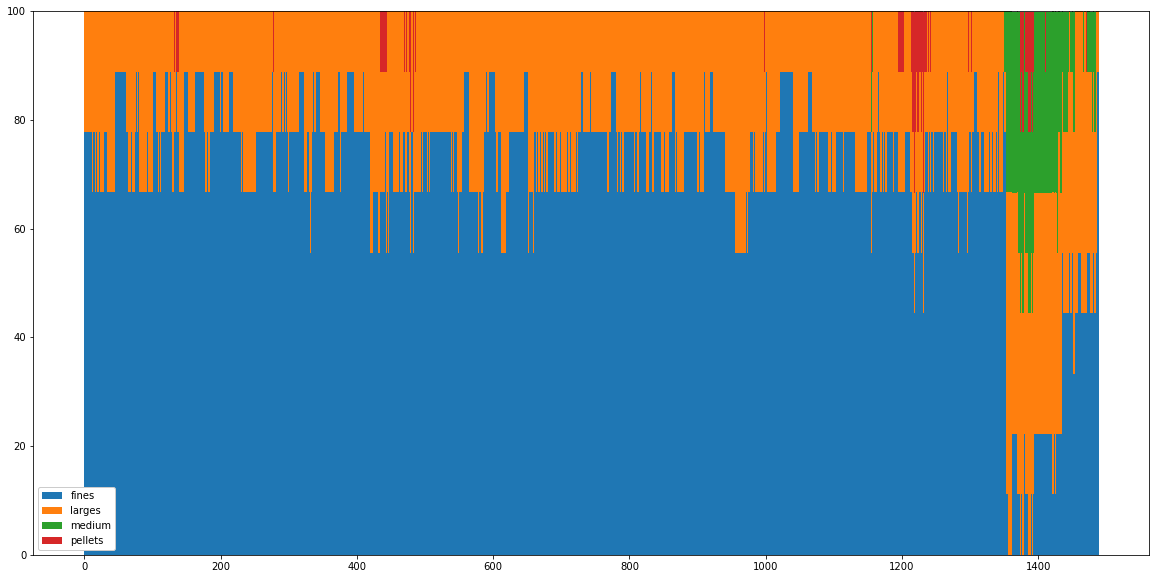

In [22]:
predictions_100 = normalise_preds(predictions)
show_graph(predictions_100)